In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(8*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.67:54009 Dashboard: http://10.148.1.67:8787/status,Cluster Workers: 21 Cores: 21 Memory: 359.94 GB


_________
# 0. Read dataset


In [5]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center


In [7]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

________
# 1. different periods (1.3, 5, 30, 90 days)

In [8]:
cut_1 = 1/30/3600
cut_5 = 1/120/3600
cut_30 = 1/24/30/3600
cut_90 = 1/24/90/3600

fs = 1/3600
nyq = 0.5*fs
cut_1d = cut_1/nyq
cut_5d = cut_5/nyq
cut_30d = cut_30/nyq
cut_90d = cut_90/nyq

b, a = butter(4, cut_1d , 'low')
c, d = butter(4, cut_5d, 'low')
e, f = butter(4, cut_30d , 'low')
g, h = butter(4, cut_90d, 'low')

In [14]:
du_dx = gridx.diff(butter_filter(ds.U, e, f), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, e, f), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, e, f), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, e, f), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, e, f), 'X')-gridx.interp(butter_filter(ds.U, e, f)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, e, f), 'Y')-gridx.interp(butter_filter(ds.V, e, f)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), e, f) -butter_filter(gridx.interp(ds.V,'Y'), e, f)*butter_filter(gridx.interp(ds.U,'X'), e, f) )*(du_dy+dv_dx)

PI_cg_30d = -(PI_1+PI_2+PI_3)
PI_cg_30d

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [ ]:
du_dx = gridx.diff(butter_filter(ds.U, g, h), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, g, h), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, g, h), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, g, h), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, g, h), 'X')-gridx.interp(butter_filter(ds.U, g, h)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, g, h), 'Y')-gridx.interp(butter_filter(ds.V, g, h)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), g, h) -butter_filter(gridx.interp(ds.V,'Y'), g, h)*butter_filter(gridx.interp(ds.U,'X'), g, h) )*(du_dy+dv_dx)

PI_cg_90d = -(PI_1+PI_2+PI_3)
PI_cg_90d

In [5]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'

depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_30d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_30d_single = PI_cg_30d.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_30d_single = PI_cg_30d_single.chunk(chunks)
        PI_cg_30d_single = np.real(PI_cg_30d_single).rename('PI_cg_30d_single')     
        PI_cg_30d_single = PI_cg_30d_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_30d_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed


In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_90d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_90d_single = PI_cg_90d.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_90d_single = PI_cg_90d_single.chunk(chunks)
        PI_cg_90d_single = np.real(PI_cg_90d_single).rename('PI_cg_90d_single')     
        PI_cg_90d_single = PI_cg_90d_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_90d_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed


___________
# 2 Read results

In [18]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_30d = xr.concat(D, dim='depth')
PI_cg_30d = PI_cg_30d.PI_cg_30d_single
print(PI_cg_30d)
print('\n data size: %.1f GB' %(PI_cg_30d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_30d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

 data size: 69.7 GB


In [19]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_90d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_90d = xr.concat(D, dim='depth')
PI_cg_90d = PI_cg_90d.PI_cg_90d_single
print(PI_cg_90d)
print('\n data size: %.1f GB' %(PI_cg_90d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_90d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

 data size: 69.7 GB


In [9]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter.zarr')
PI_cg = PI_cg.PI_cg

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD

ds = xr.merge([PI_cg,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds.PI_cg.persist()
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg       (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

# long period

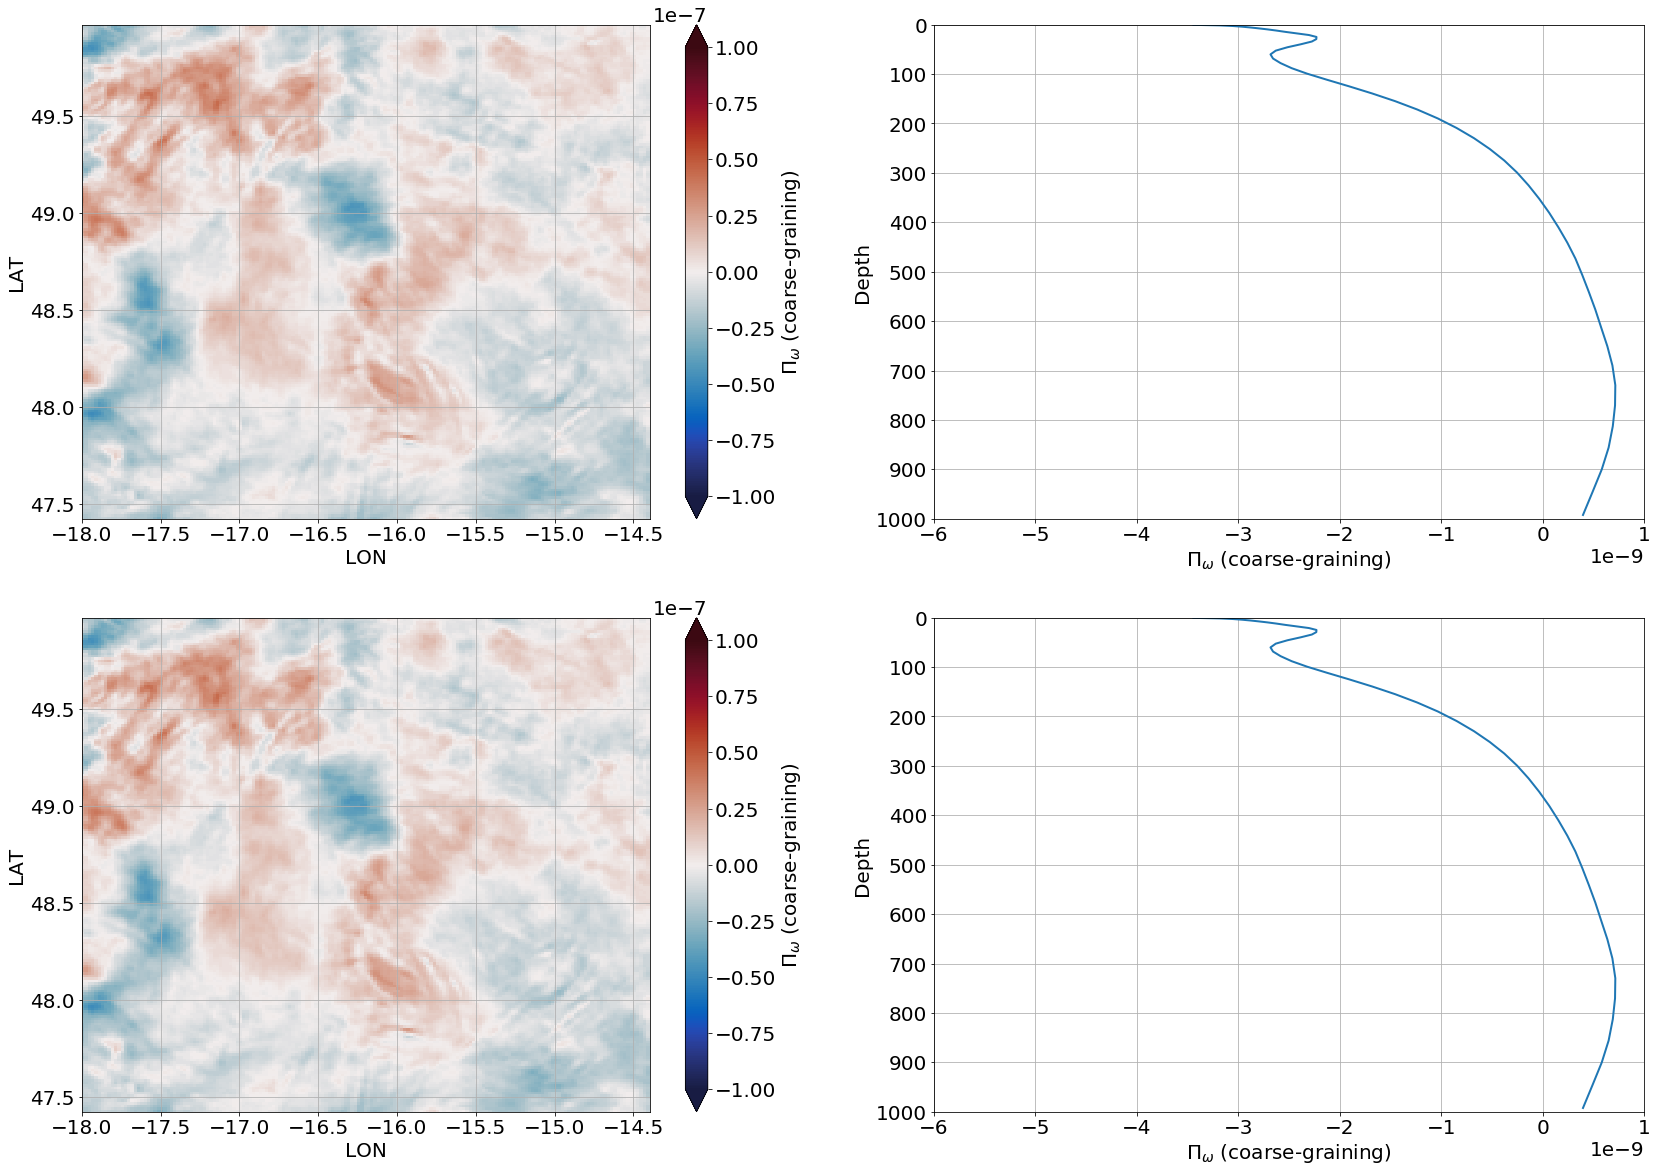

In [9]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = (PI_cg_30d).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-7,vmax=1e-7, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
(PI_cg_30d).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-6e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-6e-9, -5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


ax = plt.subplot(223)
cax = (PI_cg_90d).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-7,vmax=1e-7, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
(PI_cg_90d).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-6e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-6e-9, -5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

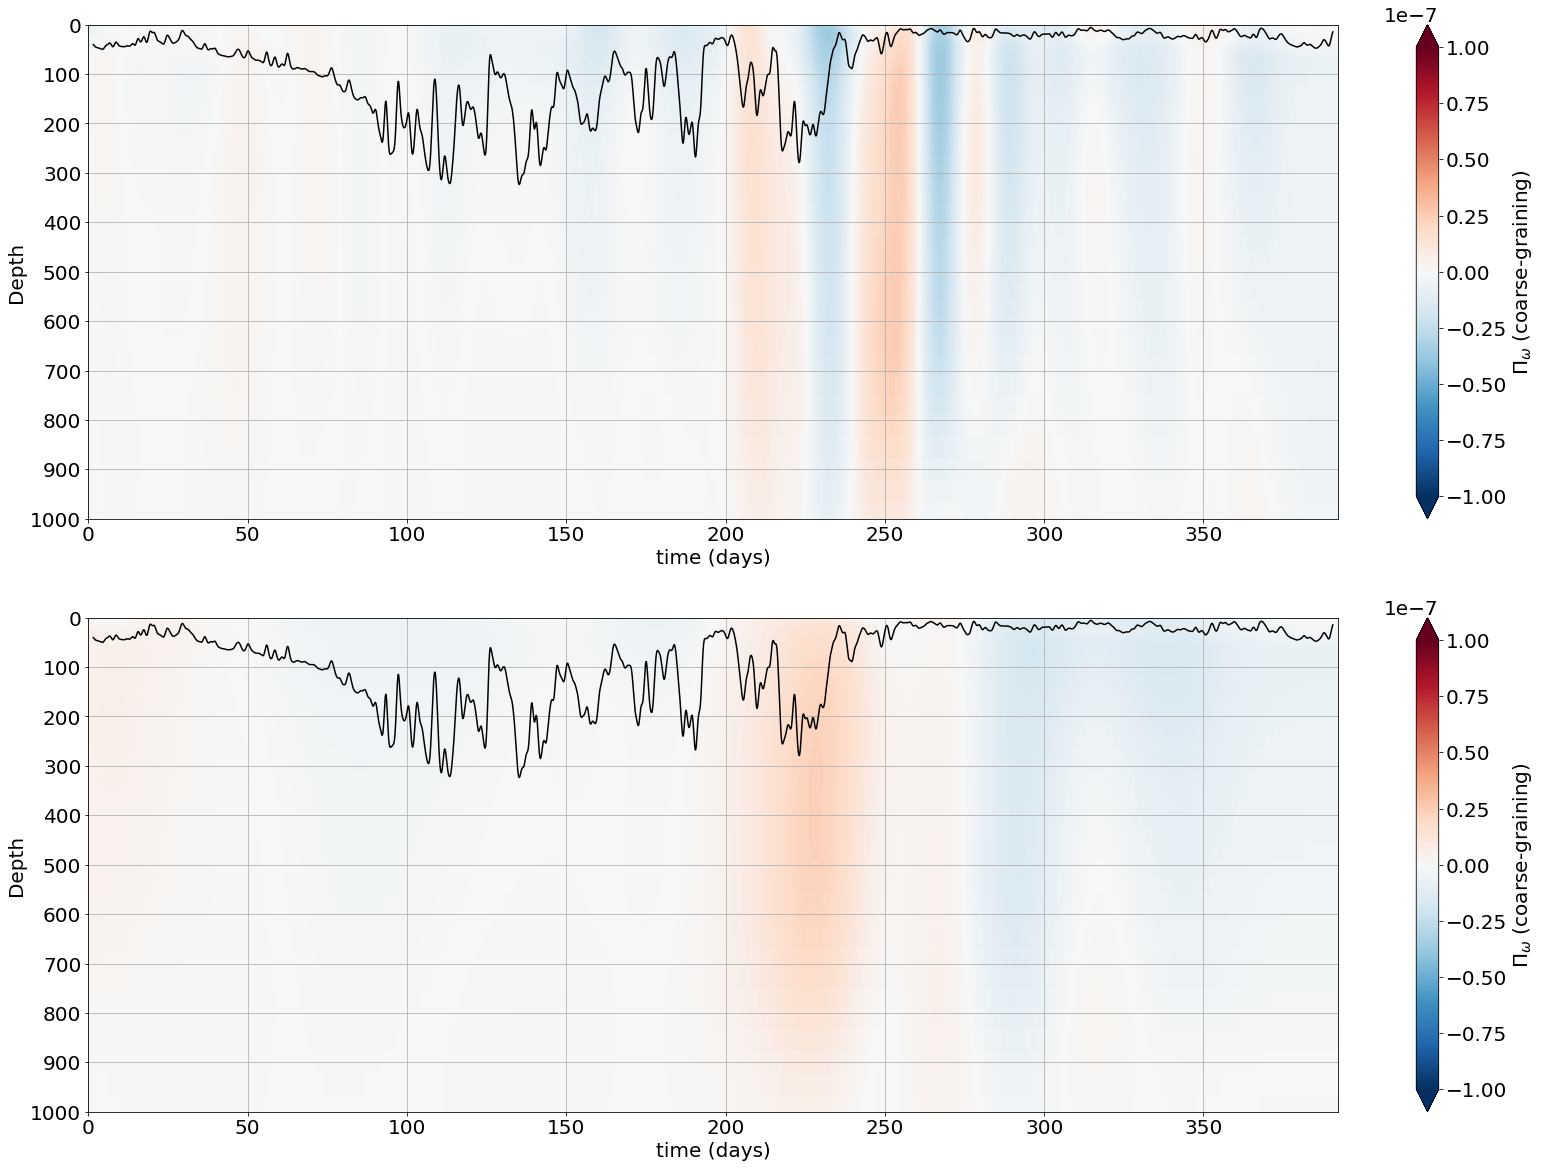

In [10]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(211)
cax = (ds_PI.PI_cg_120h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

ax = plt.subplot(212)
cax = (ds_PI.PI_cg_30h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_long_periods2.png')

In [13]:
cluster.close()